In [1]:
import numpy as np
import cv2
from math import sin, cos
import time

import pygame, sys
from pygame.locals import *

import os
import pickle

import itertools

from IPython.display import display

ModuleNotFoundError: No module named 'cv2'

In [3]:
import keras
import io
import IPython

def array_to_img(a, fmt='jpeg'):
    f = io.BytesIO()
    keras.preprocessing.image.array_to_img(a).save(f, fmt)
    return IPython.display.Image(data=f.getvalue())

In [4]:
# initialize the camera
cam = cv2.VideoCapture(0)   # 0 -> index of camera

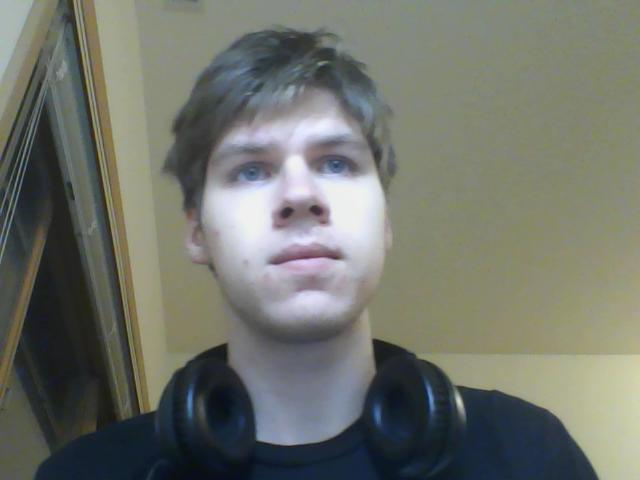

KeyboardInterrupt: 

In [5]:
image = display("", display_id='cam')
while True:
    s, frame = cam.read()
    if s:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.flip(frame, 1)
        image.update(array_to_img(frame))

In [10]:
x_data = []
y_data = []

if 'data.pickle' in os.listdir():
    print('found existing data.pickle')
    with open('data.pickle', 'rb') as f:
        x_data, y_data = pickle.load(f)
else:
    print('using empty arrays')

found existing data.pickle


In [11]:
def record_view(pos):
    s, frame = cam.read()
    if s:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x_data.append(frame)
        y_data.append(pos)

In [12]:

import pygame
import time
from pygame.locals import QUIT, KEYDOWN
from math import sin, cos

def func(t):
    return ((sin(t * 3**0.5)+1) * 1880/2, (cos(t * 2)+1) * 1040/2)


def text(font, surface, x, y, text):
    text = font.render(text, 1, (0, 0, 0))
    surface.blit(text, (x, y))

i = 0
def main():
    global i
    pygame.init()
    font = pygame.font.SysFont('Noto Sans', 14)
    cam.read()

    DISPLAY=pygame.display.set_mode((1920,1080),0,32)

    WHITE=(255,255,255)
    BLUE=(0,0,255)
    LIGHT_BLUE=(220,220,255)
    

    DISPLAY.fill(WHITE)
    
    di = 0.008
    
    start = time.time()
    last = start
    
    while True:
        for event in pygame.event.get():
            if event.type==KEYDOWN:
                if event.scancode == 36:
                    start = time.time()
                    last = start
                if event.scancode == 119:
                    pygame.quit()
                    return
            if event.type==QUIT:
                pygame.quit()
                return
                
        if time.time() < start + 5:
            i += 1
            
            pygame.draw.rect(DISPLAY,WHITE,(0, 0,400,40))
            text(font, DISPLAY, 5, 5, str(len(x_data)))
            pygame.draw.rect(DISPLAY,WHITE,(*func((i-1) * di),40,40))
            pygame.draw.rect(DISPLAY,BLUE,(*func(i * di),40,40))

            if i % 50 in range(40, 50):
                x, y = func(i * di)
                pygame.draw.rect(DISPLAY,WHITE,(x+10, y+10, 20, 20))
                
            if i % 50 == 45:
                record_view(func(i * di))

            while time.time() < last + 0.01:
                time.sleep(0.001)
            last = last + 0.01
            pygame.display.update()
    
    pygame.quit()

In [13]:
main()

In [14]:
len(x_data)

3500

In [15]:
cam.release()

In [16]:
import ipywidgets as widgets
from IPython.display import display
import IPython
import keras
import io
import face_recognition

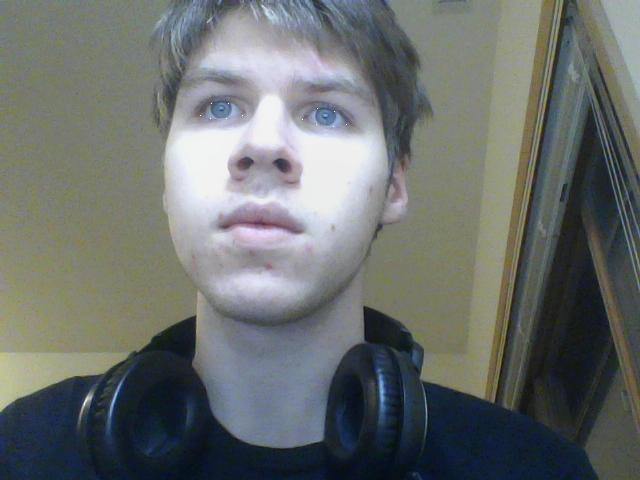

In [17]:
def show(i):
    copy = x_data[i].copy()
    landmarks = face_recognition.face_landmarks(copy)
    for face in landmarks:
        for x, y in [*face['left_eye'], *face['right_eye']]:
            copy[y][x][0] = 255
            copy[y][x][1] = 255
            copy[y][x][2] = 255
    image.update(array_to_img(copy))

def f(c):
    show(c.new)

counter = widgets.BoundedIntText(max=len(x_data)-1)
counter.observe(f, names=['value'])


def del_i(*_):
    i = counter.value
    x_data.pop(i)
    y_data.pop(i)
    counter.max = len(x_data) - 1
    show(counter.value)

delete = widgets.Button(description='delete')
delete.on_click(del_i)


display(widgets.HBox([counter, delete]))
image = display(array_to_img(x_data[0]), display_id='image')
show(0)


In [18]:
with open('data.pickle', 'wb') as file:
    pickle.dump((x_data, y_data), file)

In [13]:
from tqdm import tqdm

In [14]:
for i, im in enumerate(tqdm(x_data)):
    if not face_recognition.face_landmarks(im):
        print(i)

100%|██████████| 3000/3000 [08:32<00:00,  5.88it/s]
